## Vegetation Health Modeling using Remote Sensing and GIS study Area (Amman, Jordan)

Defining the Study Area

In [27]:
import ee, os

os.environ["GOOGLE_CLOUD_PROJECT"] = "geojo-478012"  

ee.Authenticate()   
ee.Initialize(project="geojo-478012")  

print("✅ Earth Engine initialized successfully!")


✅ Earth Engine initialized successfully!


Extracting Sentinel-2 NDVI Data (2023)

In [32]:
import geemap
from geemap.foliumap import Map
import ee
roi = ee.Geometry.Rectangle([35.75, 31.75, 36.15, 32.20])
m = Map(center=[31.95, 35.9], zoom=9)
m.addLayer(roi, {}, "ROI")
m  


Elevation (SRTM) and rainfall (CHIRPS) are added as environmental drivers

In [34]:
def add_ndvi(img):
    return img.addBands(img.normalizedDifference(['B8','B4']).rename('NDVI'))

s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterBounds(roi)
      .filterDate('2023-01-01','2023-12-31')
      .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 30))
      .map(add_ndvi))

ndvi_mean = s2.select('NDVI').mean().clip(roi)

os.makedirs("data", exist_ok=True)
geemap.ee_export_image(ndvi_mean, filename='data/ndvi_2023.tif', scale=30, region=roi)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\data\ndvi_2023.tif


Pre-Processing and Data Alignment

In [36]:
srtm   = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
chirps = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .filterBounds(roi).filterDate('2023-01-01','2023-12-31')
          .mean().rename('rain')).clip(roi)

geemap.ee_export_image(srtm,   filename='data/dem_srtm.tif',  scale=90,   region=roi)
geemap.ee_export_image(chirps, filename='data/rain_2023.tif', scale=5000, region=roi)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\data\dem_srtm.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\data\rain_2023.tif


Modeling Vegetation Health (Random Forest Regression)

R²: 0.115 RMSE: 0.053


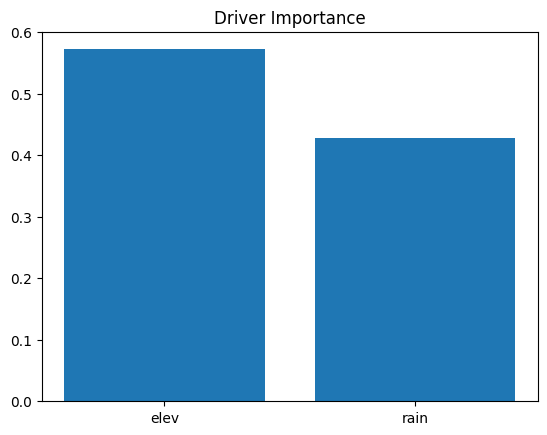

In [45]:
import rioxarray as rxr, xarray as xr, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt, os
os.makedirs("results", exist_ok=True)

ndvi = rxr.open_rasterio('data/ndvi_2023.tif').squeeze()
dem  = rxr.open_rasterio('data/dem_srtm.tif').squeeze().rio.reproject_match(ndvi)
rain = rxr.open_rasterio('data/rain_2023.tif').squeeze().rio.reproject_match(ndvi)

stack = xr.merge([ndvi.to_dataset(name='ndvi'),
                  dem.to_dataset(name='elev'),
                  rain.to_dataset(name='rain')])

df = stack.to_dataframe().reset_index().dropna()
df_s = df.sample(n=min(3000, len(df)), random_state=42)
X = df_s[['elev','rain']].values
y = df_s['ndvi'].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=150, random_state=42).fit(Xtr, ytr)
yp = rf.predict(Xte)

print("R²:", round(r2_score(yte, yp), 3),
      "RMSE:", round(np.sqrt(mean_squared_error(yte, yp)), 3))


Visualizing Results

In [ ]:
plt.bar(['elev','rain'], rf.feature_importances_)
plt.title('Driver Importance');

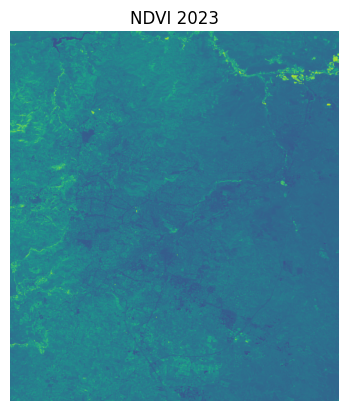

In [46]:
plt.imshow(ndvi.values, cmap='viridis')
plt.title('NDVI 2023'); plt.axis('off')

In [50]:
import folium, numpy as np

m = folium.Map(location=[31.95, 35.9], zoom_start=9)
folium.raster_layers.ImageOverlay(rgba, bounds=bounds, opacity=0.7).add_to(m)
folium.LayerControl().add_to(m)
m.save('results/ndvi_map.html')


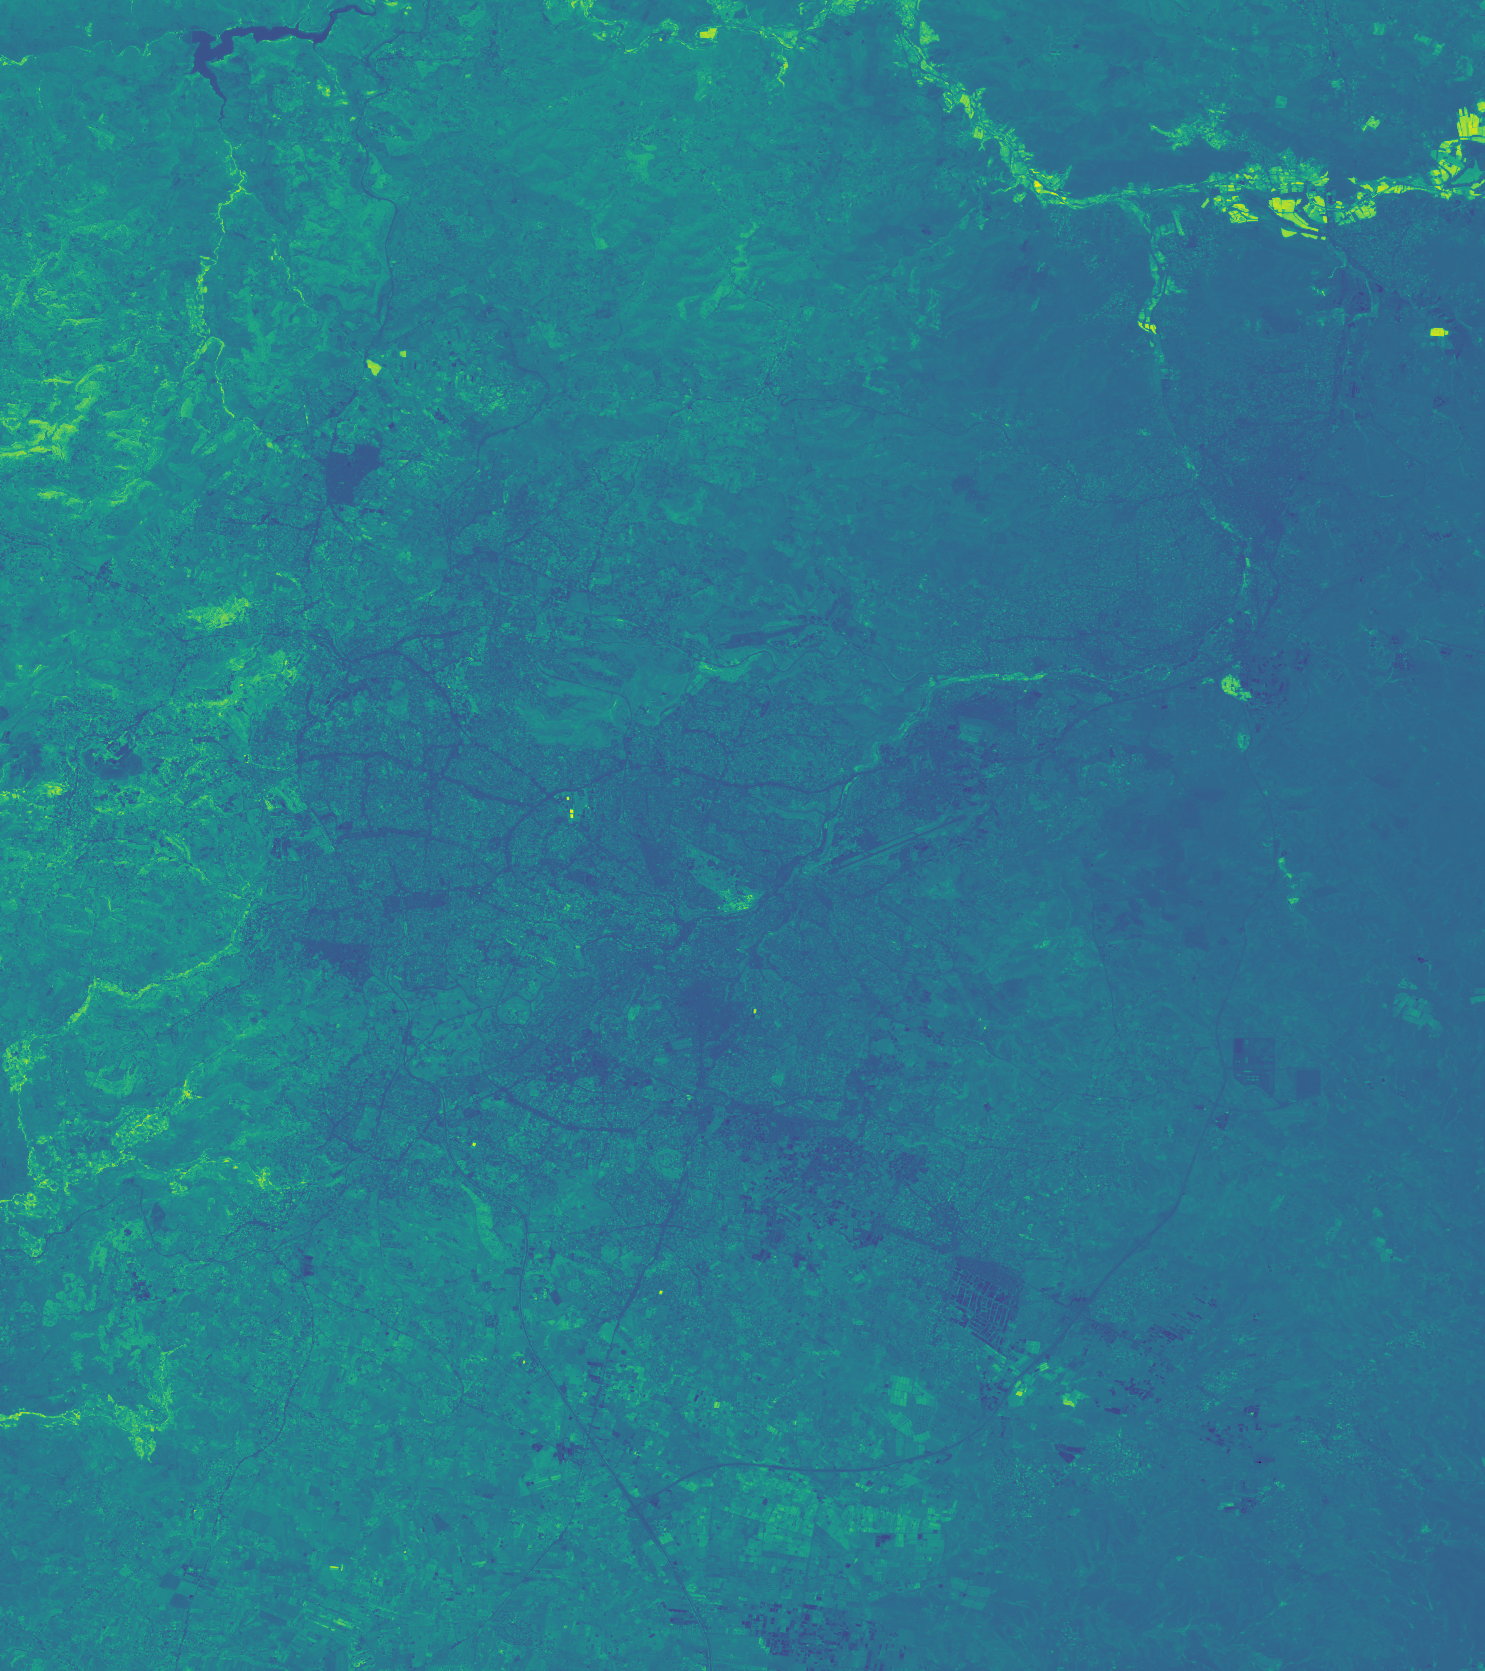

In [51]:
from IPython.display import display
display(m)   
